In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [4]:
from nmt_run import *

In [5]:
cfg_path = "./sp2enw/sp_.50"

In [6]:
last_epoch, model, optimizer, m_cfg, t_cfg = check_model(cfg_path)

cnn_out_dim = rnn_in_units =  320


/afs/inf.ed.ac.uk/group/project/lowres/work/miniconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer
--------------------------------------------------------------------------------
model found = 
./sp2enw/sp_.50/seq2seq_130.model
finished loading ..
optimizer not found


In [7]:
log_train = np.loadtxt(os.path.join(cfg_path, "train.log"), delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(os.path.join(cfg_path, "dev.log"), delimiter=',', usecols = (0,1,2)).transpose()

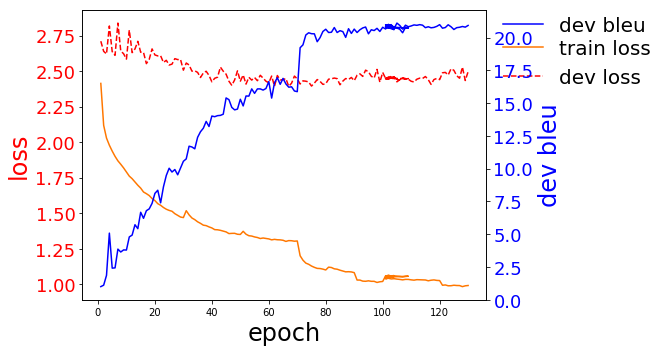

In [8]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [9]:
import nltk.translate.bleu_score

In [10]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [100]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, play_audio=False, displayN=-1):
    if displayN == -1:
        displayN = len(utts)
    es_ref = []
    en_ref = []
    en_ref2 = []
    en_ref3 = []
    en_ref4 = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))
            en_ref2.append(" ".join([w.decode() for w in m_dict[u]['en_w'][1]]))
            en_ref3.append(" ".join([w.decode() for w in m_dict[u]['en_w'][2]]))
            en_ref4.append(" ".join([w.decode() for w in m_dict[u]['en_w'][3]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    cnt = 0
    for u, es, en, en2, en3, en4, p in sorted(list(zip(utts, es_ref, en_ref, en_ref2, en_ref3, en_ref4, en_pred)))[:displayN]:
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        display_pp = PrettyTable(["cat","sent"], hrules=True)
        display_pp.align = "l"
        display_pp.header = False
        display_pp.add_row(["es ref", textwrap.fill(es,50)])
        display_pp.add_row(["en ref", textwrap.fill(en,50)])
        display_pp.add_row(["en ref2", textwrap.fill(en2,50)])
        display_pp.add_row(["en ref3", textwrap.fill(en3,50)])
        display_pp.add_row(["en ref4", textwrap.fill(en4,50)])
        
        
        display_pp.add_row(["en pred", textwrap.fill(p,50)])
        
        
        cnt += 1

        print(display_pp)
        if play_audio:
            play_utt(u, m_dict)
    

In [101]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))



In [13]:
m_cfg['model_dir']

'./sp2enw/sp_.50'

In [14]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, stemmify=False):
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
    for u in tqdm(utts, ncols=80):
        if type(m_dict[u][ref_key]) == list:
            if stemmify:
                en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
            else:
                en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_r_list = []
            for r in m_dict[u][ref_key]:
                if stemmify:
                    en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                else:
                    en_r_list.append(" ".join([w.decode() for w in r]))
            en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if stemmify:
            t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
        else:
            t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_hyp.append(t_str)

    out_fname = os.path.join(m_cfg['model_dir'], "{0:s}_mt-output".format(key))
    print("writing to file: {0:s}".format(out_fname))
    
    with open(out_fname, "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open(os.path.join(m_cfg['model_dir'], "{0:s}.ref0".format(key)), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open(os.path.join(m_cfg['model_dir'], "{0:s}_en.ref{1:d}".format(key,i)), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [15]:
train_key = m_cfg['train_set']
dev_key = m_cfg['dev_set']
batch_size=t_cfg['batch_size']
enc_key=m_cfg['enc_key']
dec_key=m_cfg['dec_key']
input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
# -------------------------------------------------------------------------
# get data dictionaries
# -------------------------------------------------------------------------
map_dict, vocab_dict, bucket_dict = get_data_dicts(m_cfg)
batch_size = {'max': 256, 'med': 256, 'min': 256, 'scale': 1}

--------------------------------------------------
loading dict: ../chainer2/speech2text/both_fbank_out/map.dict


  0%|          | 0/138708 [00:00<?, ?it/s]

loading dict: ../chainer2/speech2text/both_fbank_out/train_vocab.dict
--------------------------------------------------
--------------------------------------------------
loading info_dict from=../chainer2/speech2text/both_fbank_out/info.dict
--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 701645.90it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ../chainer2/speech2text/both_fbank_out/buckets_sp.dict
all done ...
loading dict: ../chainer2/speech2text/both_fbank_out/buckets_sp.dict
--------------------------------------------------
utterances in fisher_dev = 3979
utterances in fisher_dev2 = 3961
utterances in fisher_test = 3641
utterances in fisher_train = 138819
utterances in callhome_devtest = 3966
utterances in callhome_evltest = 1829
utterances in callhome_train = 15080
vocab size for sp = 0
vocab size for en_w = 17378


In [16]:
random.seed("meh")
# random.seed("haha")

In [17]:
pred_sents, utts, dev_loss = feed_model(model,
                                        optimizer=optimizer,
                                        m_dict=map_dict[dev_key],
                                        b_dict=bucket_dict[dev_key],
                                        vocab_dict=vocab_dict,
                                        batch_size=batch_size,
                                        x_key=enc_key,
                                        y_key=dec_key,
                                        train=False,
                                        input_path=input_path,
                                        max_dec=m_cfg['max_en_pred'],
                                        t_cfg=t_cfg,
                                        use_y=False)

b=13,l=0.00,avg=0.00: 100%|█████████████████| 3977/3977 [00:50<00:00, 78.29it/s]


In [87]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, m_cfg['max_en_pred']
min_len, max_len = 0, 1
displayN = 50
m_dict=map_dict[dev_key]
# wavs_path = os.path.join(m_cfg['data_path'], "wavs")
wavs_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "wavs")
v_dict = vocab_dict['en_w']
key = m_cfg['dev_set']

In [88]:
fsh_filt_pred, fsh_filt_utts = zip(*sorted([(p,u) for p, u in zip(pred_sents, utts) if (len(m_dict[u]['es_w']) >= min_len) and 
                                        (len(m_dict[u]['es_w']) <= max_len)]))

In [89]:
print("length filtered utterances = {0:d}".format(len(fsh_filt_utts)))

length filtered utterances = 813


In [97]:
813 / 3977, (50+115+15+171) / 3977, (50+115+15+171) / 813

(0.20442544631631884, 0.08825748051294946, 0.4317343173431734)

In [102]:
display_words(m_dict, v_dict, 
              fsh_filt_pred, 
              fsh_filt_utts, dec_key, 
              key, 
              play_audio=True, 
              displayN=displayN)

Utterance: 20051009_182032_217_fsp-A-105
+---------+-------+
| es ref  | mhm   |
+---------+-------+
| en ref  | uh um |
+---------+-------+
| en ref2 | mhm   |
+---------+-------+
| en ref3 | mhm   |
+---------+-------+
| en ref4 | hmm   |
+---------+-------+
| en pred | mhm   |
+---------+-------+
460.79 462.01


Utterance: 20051009_182032_217_fsp-A-107
+---------+-------+
| es ref  | mhm   |
+---------+-------+
| en ref  | uh um |
+---------+-------+
| en ref2 | mhm   |
+---------+-------+
| en ref3 | mhm   |
+---------+-------+
| en ref4 | hmm   |
+---------+-------+
| en pred | mhm   |
+---------+-------+
467.77 469.13


Utterance: 20051009_182032_217_fsp-A-109
+---------+-------+
| es ref  | sí    |
+---------+-------+
| en ref  | right |
+---------+-------+
| en ref2 | yes   |
+---------+-------+
| en ref3 | yes   |
+---------+-------+
| en ref4 | yes   |
+---------+-------+
| en pred | yes   |
+---------+-------+
480.91 481.57


Utterance: 20051009_182032_217_fsp-A-11
+---------+-------+
| es ref  | bueno |
+---------+-------+
| en ref  | hi    |
+---------+-------+
| en ref2 | good  |
+---------+-------+
| en ref3 | good  |
+---------+-------+
| en ref4 | well  |
+---------+-------+
| en pred | very  |
+---------+-------+
36.9 38.26


Utterance: 20051009_182032_217_fsp-A-112
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en ref2 | mhm |
+---------+-----+
| en ref3 | mhm |
+---------+-----+
| en ref4 | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
498.25 499.21


Utterance: 20051009_182032_217_fsp-A-116
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | aha   |
+---------+-------+
| en ref2 | right |
+---------+-------+
| en ref3 | aha   |
+---------+-------+
| en ref4 | aha   |
+---------+-------+
| en pred | aha   |
+---------+-------+
518.11 519.07


Utterance: 20051009_182032_217_fsp-A-117
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
523.93 525.09


Utterance: 20051009_182032_217_fsp-A-118
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en ref2 | mhm |
+---------+-----+
| en ref3 | mhm |
+---------+-----+
| en ref4 | mhm |
+---------+-----+
| en pred | mhm |
+---------+-----+
526.66 527.72


Utterance: 20051009_182032_217_fsp-A-121
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
548.95 549.71


Utterance: 20051009_182032_217_fsp-A-124
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
559.87 560.88


Utterance: 20051009_182032_217_fsp-A-127
+---------+----+
| es ref  | mm |
+---------+----+
| en ref  | mm |
+---------+----+
| en ref2 | mm |
+---------+----+
| en ref3 | mm |
+---------+----+
| en ref4 | mm |
+---------+----+
| en pred | oh |
+---------+----+
583.02 584.13


Utterance: 20051009_182032_217_fsp-A-128
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en ref2 | hmm |
+---------+-----+
| en ref3 | mhm |
+---------+-----+
| en ref4 | mhm |
+---------+-----+
| en pred | mmm |
+---------+-----+
587.26 588.53


Utterance: 20051009_182032_217_fsp-A-129
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
589.84 590.7


Utterance: 20051009_182032_217_fsp-A-131
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
598.89 599.6


Utterance: 20051009_182032_217_fsp-A-135
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
617.89 619.06


Utterance: 20051009_182032_217_fsp-A-136
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
622.44 623.2


Utterance: 20051009_182032_217_fsp-A-137
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en ref2 | mhm |
+---------+-----+
| en ref3 | hmm |
+---------+-----+
| en ref4 | mhm |
+---------+-----+
| en pred | hmm |
+---------+-----+
626.03 627.9


Utterance: 20051009_182032_217_fsp-A-14
+---------+-----+
| es ref  | ¿si |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
44.73 45.34


Utterance: 20051009_182032_217_fsp-A-140
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
648.63 649.64


Utterance: 20051009_182032_217_fsp-A-141
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en ref2 | hmm |
+---------+-----+
| en ref3 | mm  |
+---------+-----+
| en ref4 | mhm |
+---------+-----+
| en pred | mm  |
+---------+-----+
653.83 654.69


Utterance: 20051009_182032_217_fsp-A-142
+---------+-----+
| es ref  | wow |
+---------+-----+
| en ref  | wow |
+---------+-----+
| en ref2 | wow |
+---------+-----+
| en ref3 | wow |
+---------+-----+
| en ref4 | wow |
+---------+-----+
| en pred | wow |
+---------+-----+
658.33 659.34


Utterance: 20051009_182032_217_fsp-A-145
+---------+-----------+
| es ref  | claro     |
+---------+-----------+
| en ref  | of course |
+---------+-----------+
| en ref2 | of course |
+---------+-----------+
| en ref3 | sure      |
+---------+-----------+
| en ref4 | of course |
+---------+-----------+
| en pred | sure      |
+---------+-----------+
667.99 669.1


Utterance: 20051009_182032_217_fsp-A-147
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | hmm |
+---------+-----+
| en ref2 | hmm |
+---------+-----+
| en ref3 | mm  |
+---------+-----+
| en ref4 | mhm |
+---------+-----+
| en pred | hmm |
+---------+-----+
674.51 675.67


Utterance: 20051009_182032_217_fsp-A-149
+---------+------------+
| es ref  | claro      |
+---------+------------+
| en ref  | of course  |
+---------+------------+
| en ref2 | of courses |
+---------+------------+
| en ref3 | of course  |
+---------+------------+
| en ref4 | of course  |
+---------+------------+
| en pred | sure       |
+---------+------------+
684.36 685.63


Utterance: 20051009_182032_217_fsp-A-152
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
704.13 704.89


Utterance: 20051009_182032_217_fsp-A-153
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mhm |
+---------+-----+
| en ref2 | mhm |
+---------+-----+
| en ref3 | mmh |
+---------+-----+
| en ref4 | hmm |
+---------+-----+
| en pred | mhm |
+---------+-----+
712.22 713.38


Utterance: 20051009_182032_217_fsp-A-154
+---------+-----------+
| es ref  | claro     |
+---------+-----------+
| en ref  | i see     |
+---------+-----------+
| en ref2 | ofcourse  |
+---------+-----------+
| en ref3 | of course |
+---------+-----------+
| en ref4 | sure      |
+---------+-----------+
| en pred | wow       |
+---------+-----------+
715.0 716.31


Utterance: 20051009_182032_217_fsp-A-37
+---------+--------+
| es ref  | ¿si    |
+---------+--------+
| en ref  | yes    |
+---------+--------+
| en ref2 | really |
+---------+--------+
| en ref3 | yes    |
+---------+--------+
| en ref4 | yes    |
+---------+--------+
| en pred | yes    |
+---------+--------+
141.38 141.89


Utterance: 20051009_182032_217_fsp-A-42
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
155.18 156.14


Utterance: 20051009_182032_217_fsp-A-43
+---------+-------+
| es ref  | ajá   |
+---------+-------+
| en ref  | aha   |
+---------+-------+
| en ref2 | aha   |
+---------+-------+
| en ref3 | right |
+---------+-------+
| en ref4 | aha   |
+---------+-------+
| en pred | aha   |
+---------+-------+
163.37 164.84


Utterance: 20051009_182032_217_fsp-A-44
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
167.82 168.53


Utterance: 20051009_182032_217_fsp-A-45
+---------+-------+
| es ref  | mhm   |
+---------+-------+
| en ref  | mmh   |
+---------+-------+
| en ref2 | mhm   |
+---------+-------+
| en ref3 | uh um |
+---------+-------+
| en ref4 | hmm   |
+---------+-------+
| en pred | mhm   |
+---------+-------+
171.51 172.72


Utterance: 20051009_182032_217_fsp-A-46
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
176.66 177.67


Utterance: 20051009_182032_217_fsp-A-47
+---------+-------+
| es ref  | mhm   |
+---------+-------+
| en ref  | mmh   |
+---------+-------+
| en ref2 | mhm   |
+---------+-------+
| en ref3 | uh um |
+---------+-------+
| en ref4 | hmm   |
+---------+-------+
| en pred | mm    |
+---------+-------+
180.66 181.77


Utterance: 20051009_182032_217_fsp-A-48
+---------+-----------+
| es ref  | claro     |
+---------+-----------+
| en ref  | of course |
+---------+-----------+
| en ref2 | clearly   |
+---------+-----------+
| en ref3 | right     |
+---------+-----------+
| en ref4 | sure      |
+---------+-----------+
| en pred | wow       |
+---------+-----------+
187.23 188.39


Utterance: 20051009_182032_217_fsp-A-50
+---------+------+
| es ref  | sí   |
+---------+------+
| en ref  | yes  |
+---------+------+
| en ref2 | yes  |
+---------+------+
| en ref3 | yes  |
+---------+------+
| en ref4 | yess |
+---------+------+
| en pred | yes  |
+---------+------+
194.2 195.21


Utterance: 20051009_182032_217_fsp-A-52
+---------+--------+
| es ref  | mhm    |
+---------+--------+
| en ref  | uh huh |
+---------+--------+
| en ref2 | hmm    |
+---------+--------+
| en ref3 | hmmm   |
+---------+--------+
| en ref4 | hmm    |
+---------+--------+
| en pred | mhm    |
+---------+--------+
215.43 216.29


Utterance: 20051009_182032_217_fsp-A-53
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ok |
+---------+----+
| en ref2 | oh |
+---------+----+
| en ref3 | ah |
+---------+----+
| en ref4 | ah |
+---------+----+
| en pred | oh |
+---------+----+
216.9 217.66


Utterance: 20051009_182032_217_fsp-A-55
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
224.43 226.4


Utterance: 20051009_182032_217_fsp-A-56
+---------+------+
| es ref  | ajá  |
+---------+------+
| en ref  | ok   |
+---------+------+
| en ref2 | aha  |
+---------+------+
| en ref3 | yeah |
+---------+------+
| en ref4 | aha  |
+---------+------+
| en pred | aha  |
+---------+------+
227.67 228.78


Utterance: 20051009_182032_217_fsp-A-58
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
238.94 239.85


Utterance: 20051009_182032_217_fsp-A-75
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
313.4 314.25


Utterance: 20051009_182032_217_fsp-A-76
+---------+--------+
| es ref  | ajá    |
+---------+--------+
| en ref  | uh huh |
+---------+--------+
| en ref2 | yeah   |
+---------+--------+
| en ref3 | right  |
+---------+--------+
| en ref4 | right  |
+---------+--------+
| en pred | aha    |
+---------+--------+
316.12 317.09


Utterance: 20051009_182032_217_fsp-A-77
+---------+--------+
| es ref  | ajá    |
+---------+--------+
| en ref  | uh huh |
+---------+--------+
| en ref2 | yeah   |
+---------+--------+
| en ref3 | right  |
+---------+--------+
| en ref4 | right  |
+---------+--------+
| en pred | aha    |
+---------+--------+
325.27 326.13


Utterance: 20051009_182032_217_fsp-A-78
+---------+-------+
| es ref  | mhm   |
+---------+-------+
| en ref  | hmm   |
+---------+-------+
| en ref2 | mhm   |
+---------+-------+
| en ref3 | mhm   |
+---------+-------+
| en ref4 | right |
+---------+-------+
| en pred | mhm   |
+---------+-------+
329.37 330.63


Utterance: 20051009_182032_217_fsp-A-79
+---------+-----+
| es ref  | sí  |
+---------+-----+
| en ref  | yes |
+---------+-----+
| en ref2 | yes |
+---------+-----+
| en ref3 | yes |
+---------+-----+
| en ref4 | yes |
+---------+-----+
| en pred | yes |
+---------+-----+
339.07 340.03


Utterance: 20051009_182032_217_fsp-A-81
+---------+-------------+
| es ref  | sí          |
+---------+-------------+
| en ref  | yes         |
+---------+-------------+
| en ref2 | yes         |
+---------+-------------+
| en ref3 | yes         |
+---------+-------------+
| en ref4 | yes         |
+---------+-------------+
| en pred | it ' s true |
+---------+-------------+
352.72 353.98


Utterance: 20051009_182032_217_fsp-A-87
+---------+------+
| es ref  | sí   |
+---------+------+
| en ref  | yes  |
+---------+------+
| en ref2 | yeah |
+---------+------+
| en ref3 | yes  |
+---------+------+
| en ref4 | yes  |
+---------+------+
| en pred | yes  |
+---------+------+
381.99 382.8


Utterance: 20051009_182032_217_fsp-A-88
+---------+------+
| es ref  | sí   |
+---------+------+
| en ref  | yes  |
+---------+------+
| en ref2 | yeah |
+---------+------+
| en ref3 | yes  |
+---------+------+
| en ref4 | yes  |
+---------+------+
| en pred | yes  |
+---------+------+
388.41 389.67


Utterance: 20051009_182032_217_fsp-B-1
+---------+-----------+
| es ref  | tardes    |
+---------+-----------+
| en ref  | afternoon |
+---------+-----------+
| en ref2 | afternoon |
+---------+-----------+
| en ref3 | afternoon |
+---------+-----------+
| en ref4 | afternoon |
+---------+-----------+
| en pred | perhaps   |
+---------+-----------+
0.05 0.86


In [82]:
es_ref = []
en_ref = []
for u in fsh_filt_utts:
    es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
    if type(m_dict[u][dec_key]) == list:
        en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
    else:
        en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

en_pred = []
join_str = ' ' if dec_key.endswith('_w') else ''

In [83]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/speech2text")

In [84]:
b, chrf, h, r = calc_bleu(m_dict, 
                          v_dict, 
                          fsh_filt_pred, 
                          fsh_filt_utts, 
                          dec_key, 
                          ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

model_refs = {u: mr for u, mr in zip(fsh_filt_utts, r)}
model_hyps = {u: mh for u, mh in zip(fsh_filt_utts, h)}

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 51704.97it/s]


BLEU score on: fisher_dev = 20.87
------------------------------------------------------------


In [85]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
                                           dec_key, key, stemmify=False)

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 86797.52it/s]

writing to file: ./sp2enw/sp_.50/fisher_dev_mt-output
done


In [86]:
len(en_hyp)

3977

In [27]:
_, _ = corpus_precision_recall(r, h)

total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    55.06 |    27.73|    14.93 |     8.31
recall     |    32.49 |    12.27|     5.68 |     2.88


In [28]:
model_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}

for utt_id, ref, hyp in zip(fsh_filt_utts, r, h):
    es_ref = [w.decode() for w in m_dict[utt_id]['es_w']]
    
    pval, rval = modified_precision_recall(ref, hyp, n=1)
    model_prec_recall['tc'] += pval.numerator
    model_prec_recall['tp'] += pval.denominator
    model_prec_recall['tr'] += rval.denominator

    model_prec_recall['precision'][utt_id] = float(pval)
    model_prec_recall['recall'][utt_id] = float(rval)
# end for
    
model_prec_recall['total_precision'] = model_prec_recall['tc'] / model_prec_recall['tp']
model_prec_recall['total_recall'] = model_prec_recall['tc'] / model_prec_recall['tr']

In [29]:
print("\t\tModel metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      model_prec_recall['total_precision'],
                                                      "recall",
                                                      model_prec_recall['total_recall']))


		Model metrics
------------------------------------------------------------
precision  = 0.551
recall     = 0.325


In [30]:
print("model-s2t BLEU score:")
"{0:0.3f}".format(100.0 * corpus_bleu(model_refs.values(), model_hyps.values()))

model-s2t BLEU score:


'20.865'

In [31]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
_, _ = corpus_precision_recall(model_refs.values(), model_hyps.values())

------------------------------------------------------------
		MODEL
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    55.06 |    27.73|    14.93 |     8.31
recall     |    32.49 |    12.27|     5.68 |     2.88


In [32]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
metrics = {"p": {1: [], 2: [], 3: [], 4: []},
           "r": {1: [], 2: [], 3: [], 4: []}}

for ix in range(len(list(model_refs.values())[0])):
    temp_refs = [[i[ix]] for i in model_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    ps, rs = corpus_precision_recall(temp_refs, model_hyps.values())
    for i, (p, r) in enumerate(zip(ps, rs)):
        metrics['p'][i+1].append(p)
        metrics['r'][i+1].append(r)
    

------------------------------------------------------------
		MODEL
------------------------------------------------------------
------------------------------------------------------------
		Using reference = 1
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    40.32 |    16.81|     8.09 |     4.27
recall     |    42.20 |    17.68|     8.54 |     4.53
------------------------------------------------------------
		Using reference = 2
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    40.58 |    17.18|     8.40 |     4.47
recall     |    42.41 |    18.04|     8.85 |     4.73
------------------------------------------------------------
		Using reference = 3
---------------------------------

In [33]:
def get_mean_std(vals_dict):
#     print("estimated mean")
    k = []
    u = []
    s = []
    for m, vals in vals_dict.items():
        k.append(m)
        u.append(np.mean(vals))
        s.append(np.std(vals)/np.sqrt(len(vals)))
        print("{0:10d}-gram = {1:.2f} ± {2:.2f}".format(m, np.mean(vals), np.std(vals)/np.sqrt(len(vals))))
        
    print(",".join(map(lambda x : "{0:.2f}".format(x), u)))
    print(",".join(map(lambda x : "{0:.2f}".format(x), s)))
    return k, u, s

In [34]:
s2w_p_r = {}

print("Precision:")
_, s2w_p_r['p'], s2w_p_r['p_std'] = get_mean_std(metrics['p'])

print("Recall:")
_, s2w_p_r['r'], s2w_p_r['r_std'] = get_mean_std(metrics['r'])

Precision:
         1-gram = 40.56 ± 0.08
         2-gram = 17.12 ± 0.09
         3-gram = 8.26 ± 0.06
         4-gram = 4.31 ± 0.05
40.56,17.12,8.26,4.31
0.08,0.09,0.06,0.05
Recall:
         1-gram = 42.31 ± 0.05
         2-gram = 17.93 ± 0.07
         3-gram = 8.70 ± 0.06
         4-gram = 4.55 ± 0.06
42.31,17.93,8.70,4.55
0.05,0.07,0.06,0.06


In [35]:
with open(os.path.join(m_cfg['model_dir'], "s2w_p_r.json"), "w") as out_f:
    json.dump(s2w_p_r, out_f, indent=4)

In [36]:
model_predictions = {}
for u, hyp in zip(fsh_filt_utts, h):
    model_predictions[u] = hyp

### word level analysis

In [37]:
top_k = 100
min_word_len = 1

In [38]:
stop_words = set(nltk.corpus.stopwords.words("english"))
len(stop_words)

127

In [39]:
def get_words(m_dict):
    words = []
    for u in m_dict:
        if type(m_dict[u]['en_w']) == list:
            words.extend([w.decode() for w in m_dict[u]['en_w']])
        else:
            for ref in m_dict[u]['en_w']:
                words.extend([w.decode() for w in ref])
    return Counter(words)

In [40]:
# words in train
train_words = get_words(map_dict['fisher_train'])
train_words_top_k = [(w,f) for w, f in sorted(train_words.items(), reverse=True, key=lambda t:t[1]) 
                     if w not in stop_words and len(w) >= min_word_len][:top_k]

train_only_words = set(train_words.keys())

print("{0:20s} | {1:10d}".format("# train word types", len(train_words)))
print("{0:20s} | {1:10d}".format("# train word tokens", sum(train_words.values())))

# train word types   |      17374
# train word tokens  |    1554177


In [41]:
train_words_top_k[:5]

[("'", 55741),
 ('yes', 35068),
 ('like', 14349),
 ('well', 12364),
 ('know', 10621)]

In [42]:
[(w,f) for w,f in train_words_top_k if "'" in w]

[("'", 55741)]

In [43]:
dev_words = get_words(map_dict['fisher_dev'])
dev_words_top_k = [(w,f) for w, f in sorted(dev_words.items(), reverse=True, key=lambda t:t[1]) 
                     if w not in stop_words and len(w) >= min_word_len][:top_k]

dev_only_words = set(dev_words.keys())

In [44]:
dev_words_top_k[:5]

[("'", 4820), ('yes', 3670), ('like', 1829), ('know', 1298), ('oh', 1230)]

In [45]:
oov_words = {w:f for w,f in dev_words.items() if w not in train_only_words}

In [46]:
print("{0:20s} | {1:10d}".format("# dev word types", len(dev_only_words)))
print("{0:20s} | {1:10d}".format("# dev word tokens", sum(dev_words.values())))

print("{0:20s} | {1:10d}".format("# oov word types", len(oov_words)))
print("{0:20s} | {1:10d}".format("# oov word tokens", sum(oov_words.values())))


# dev word types     |       4674
# dev word tokens    |     170346
# oov word types     |        874
# oov word tokens    |       1434


In [47]:
"{0:.1f}%".format(sum(oov_words.values()) / sum(dev_words.values()) * 100)

'0.8%'

Look at utterances which our model is doing better at, and compare to Google.

Are we doing better on a few calls only? Is there any particular speaker or call messing up our results?

### Query task

In [48]:
crises_lex_fname = "../criseslex/CrisisLexLexicon/CrisisLexRec.txt"
train_text_fname= "../installs/fisher-callhome-corpus/corpus/ldc/fisher_train.en"
topics_fname = "../criseslex/fsp06_topics_in_english.txt"

In [244]:
topics = [ "peace", "Music", "Marriage", "Religion", "Cell phones", 
           "Dating", "Telemarketing and SPAM", "Politics", "Travel", 
           "Technical devices", "Healthcare", "Advertisements", "Power", 
           "Occupations", "Movies", "Welfare", "Breaking up", "Location", 
           "Justice", "Memories", "Crime", "Violence against women", "Equality", 
            "Housing", "Immigration",     
            # new topics
           "Interracial", "Christians", "muslims", "jews", "e-mail", 
           "phone", "democracy", "Democratic", "Republican", "technology", 
           "leadership", "community", "jury", "police", "inequality", 
           "renting", "Violence", "immigrants", "immigrant", "skilled", 
           "Telemarketing", "SPAM", "skill", "job", "health", "mobile", 
            "ads", "physical", "emotional", "bubble", "rent", "economy", 
            "abuse", "women", "city", "country", "suburban", "dollar", 
            "united states", "laws", "phone", "race", "biracial", "interracial", 
            "marriage", "lyrics", "sexuality", "medicine", "television", "european",
            "home", "protect", "spouse", "language", "cellphone", "money",
            "doctor", "insurance", "cigarettes", "alcohol", "income", "salary",
            "class", "censor", "rating", "programs", "government",
            "relationship", "legal", "event", "life", "safe", "victim", "cops",
            "wage", "illegal"
            ]
topics = list(set(t.lower() for t in topics))
topics_stem = [stem(t) for t in topics]

In [245]:
dev_words_stem = {}
for w in dev_words:
    stem_w = stem(w)
    if stem_w not in dev_words_stem:
        dev_words_stem[stem_w] = 0
    dev_words_stem[stem_w] += dev_words[w]
# end for

In [246]:
len(topics)

98

In [262]:
# NOTE this checks for # of occurrences of the word in the specified text
# We later use the # of utterrances, which will be lower or equal to this number
prune_topics = [t for t in topics if dev_words_stem.get(stem(t),0) > 10 and dev_words_stem.get(stem(t),0) < 100]
len(prune_topics)

33

In [263]:
prune_topics[:5]

['christians', 'women', 'rent', 'language', 'immigrant']

In [264]:
random.seed("selec_query_terms")
sel_topics = random.sample(prune_topics, min(len(prune_topics), 100))

In [265]:
len(sel_topics)

33

In [266]:
def find_all_terms_references(utt_text, terms, text_key="en_w"):
    terms_set = set([stem(i) for i in terms])
    terms_search_res = {}
    full_words = {}

    for u in tqdm(utt_text, ncols=80):
        l = (utt_text[u][text_key] if type(utt_text[u]) == dict 
             else utt_text[u])
        for r in l:
            for w in set(r):
                decoded_w = w.decode() if type(w) != str else w
                w_to_search = stem(decoded_w)
                if w_to_search in terms_set:
                    if w_to_search not in terms_search_res:
                        terms_search_res[w_to_search] = set()
                        full_words[w_to_search] = set()
                    terms_search_res[w_to_search].add(u)
                    full_words[w_to_search].add(decoded_w)
                # end if found
            # end for current reference
        # end for all references
    # end for all utterances
    return terms_search_res, full_words


def find_all_terms_predictions(utt_text, terms):
    terms_set = set([stem(i) for i in terms])
    terms_search_res = {}
    full_words = {}

    for u in tqdm(utt_text, ncols=80):
        r = utt_text[u]
        for w in set(r):
            w_to_search = stem(w)
            if w_to_search in terms_set:
                if w_to_search not in terms_search_res:
                    terms_search_res[w_to_search] = set()
                    full_words[w_to_search] = set()
                terms_search_res[w_to_search].add(u)
                full_words[w_to_search].add(u)
                # end if found
            # end for current reference
    # end for all utterances
    return terms_search_res, full_words

In [267]:
def terms_prec_recall(preds, refs):
    prec_recall = {}
    prec_recall = {'t':0, 'tp':0, 'tc':0, 'terms':{}}
    for term in refs.keys():
        prec_recall['terms'][term] = {}
        prec_recall['terms'][term]['t'] = len(refs[term])
        preds_occ = preds.get(term, set())
        prec_recall['terms'][term]['tp'] = len(preds_occ)
        prec_recall['terms'][term]['tc'] = len(refs[term] & preds_occ)
        prec_recall['t'] += prec_recall['terms'][term]['t']
        prec_recall['tp'] += prec_recall['terms'][term]['tp']
        prec_recall['tc'] += prec_recall['terms'][term]['tc']
    # end for each term
    return prec_recall

In [268]:
ref_topics, ref_topic_labels = find_all_terms_references(map_dict['fisher_dev'], sel_topics)
pred_topics, pred_topics_topics_labels = find_all_terms_predictions(model_predictions, sel_topics)

100%|█████████████████████████████████████| 3977/3977 [00:00<00:00, 8027.39it/s]


In [269]:
len(ref_topics), len(pred_topics)

(30, 27)

In [270]:
ref_topics

{'alcohol': {'20051010_212418_225_fsp-A-20',
  '20051010_212418_225_fsp-A-22',
  '20051018_210220_279_fsp-A-74'},
 'christian': {'20051009_182032_217_fsp-A-27',
  '20051009_182032_217_fsp-A-31',
  '20051009_182032_217_fsp-B-126',
  '20051009_182032_217_fsp-B-145',
  '20051009_182032_217_fsp-B-49',
  '20051009_182032_217_fsp-B-55',
  '20051009_210519_219_fsp-A-47',
  '20051009_210519_219_fsp-B-27'},
 'class': {'20051016_180547_265_fsp-B-10',
  '20051016_180547_265_fsp-B-2',
  '20051016_180547_265_fsp-B-5',
  '20051016_180547_265_fsp-B-6',
  '20051016_180547_265_fsp-B-7',
  '20051017_180712_270_fsp-B-25',
  '20051019_190221_288_fsp-A-78',
  '20051022_180817_311_fsp-A-59',
  '20051022_180817_311_fsp-A-68',
  '20051024_180453_327_fsp-A-7',
  '20051024_180453_327_fsp-B-27',
  '20051024_180453_327_fsp-B-28',
  '20051024_180453_327_fsp-B-34',
  '20051024_180453_327_fsp-B-35',
  '20051024_180453_327_fsp-B-38',
  '20051024_180453_327_fsp-B-8',
  '20051024_181110_329_fsp-A-66',
  '20051024_18111

In [271]:
prune_topics_in_utts = {k:v for k, v in ref_topics.items() if len(v) >=3}

In [273]:
len(prune_topics_in_utts)

30

In [274]:
from  matplotlib.ticker import FuncFormatter

In [275]:
sns.set_style("darkgrid")

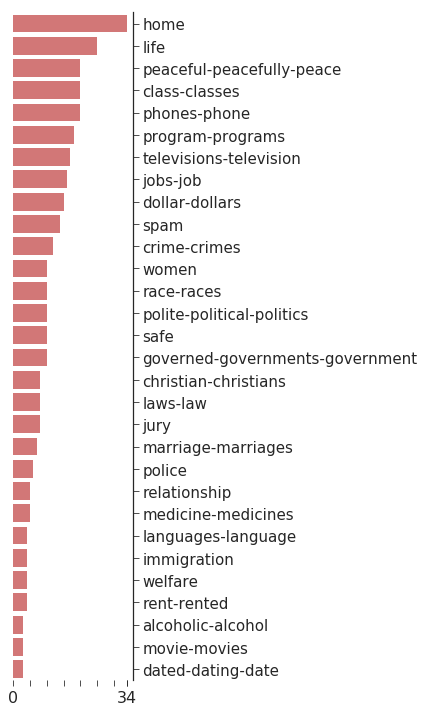

In [276]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6,10),nrows=1, ncols=1)


sorted_counts = [t[0] for t in sorted(ref_topics.items(), reverse=True, key=lambda t:len(t[1]))]
topic_count = [len(ref_topics[t]) for t in sorted_counts]

topic_labels = ["-".join(list(ref_topic_labels[t])[:3]) for t in sorted_counts]

ax = sns.barplot(x=topic_count, 
                 y=topic_labels, 
                 color=tableau20[6], alpha=.7)
                 #**{"label":"topic counts", "alpha":0.5}, ax=ax)

# ax.set_xlabel("# of utts in which topic occurs", size=20)

max_count_val = max([len(v) for v in ref_topics.values()])
min_count_val = max([len(v) for v in ref_topics.values()])
plt.xticks(list(range(0,max_count_val, 5))+[min_count_val, max_count_val])

# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9),
#                       ncol=1, fancybox=True, shadow=True, fontsize=20)

sns.despine(left=True, bottom=True, top=True, right=False)

for t in ax.get_yticklabels():
    t.set_fontsize(15) 
    
for i, t in enumerate(ax.get_xticklabels()):
    if i > 0 and i < (len(ax.get_xticklabels())-1):
        t.set_visible(False)
    else:
        t.set_fontsize(16)

fig.tight_layout()


fig.savefig("../criseslex/sel_topics_new.png", dpi=300)

In [277]:
model_topics_p_r = terms_prec_recall(preds = pred_topics, refs = ref_topics)

In [278]:
model_topics_p_r['precision'] = model_topics_p_r['tc'] / model_topics_p_r['tp']
model_topics_p_r['recall'] = model_topics_p_r['tc'] / model_topics_p_r['t']

In [279]:
print("-"*40)
print("-------------- Query by Text")
print("-"*40)
print("{0:20s} | {1:5.2f}%".format("precision", model_topics_p_r['precision']*100.0))
print("{0:20s} | {1:5.2f}%".format("recall", model_topics_p_r['recall']*100.0))

----------------------------------------
-------------- Query by Text
----------------------------------------
precision            | 43.56%
recall               | 39.64%


In [280]:
with open(os.path.join(m_cfg['model_dir'], "topics_p_r.json"), "w") as out_f:
    json.dump(model_topics_p_r, out_f, indent=4)

In [281]:
def find_all_terms_es_references(utt_text, term):
    terms_search_res = set()
    total_word_count = 0

    for u in tqdm(utt_text, ncols=80):
        l = (utt_text[u]["es_w"] if type(utt_text[u]) == dict 
             else utt_text[u])
        if len(l) == 1 and l[0].decode() == term:
            terms_search_res.add(u)
            total_word_count += 1
            # end if found
        # end for current reference
        # end for all references
    # end for all utterances
    return terms_search_res, total_word_count


In [282]:
hmm, tot_count = find_all_terms_es_references(map_dict['fisher_dev'], 'claro')

100%|███████████████████████████████████| 3979/3979 [00:00<00:00, 300002.44it/s]


In [283]:
len(hmm)

45

In [284]:
all_ref_words = {}
all_match_count = 0
no_match_count = 0

utt_refs_set = {}
for utt in hmm:
    #print("-"*60)
    #print(utt)
    curr_ref = {k : "" for k in range(4)}
    for i, r in enumerate(map_dict['fisher_dev'][utt]["en_w"]):
        en_ref_words = " ".join(w.decode() for w in r)
        curr_ref[i] = en_ref_words
        #print(" ".join(w.decode() for w in r), end="----")
        if en_ref_words not in all_ref_words:
            all_ref_words[en_ref_words] = 0
        all_ref_words[en_ref_words] += 1
    #print(curr_ref.values())

    
    utt_refs_set[utt] = set(curr_ref.values())
        

In [285]:
len(utt_refs_set['20051023_232057_325_fsp-B-77'])

4

In [286]:
start_set = utt_refs_set['20051023_232057_325_fsp-B-77']
for utt in utt_refs_set:
    start_set = start_set & utt_refs_set[utt]

In [287]:
start_set

set()

In [288]:
start_set

set()

In [235]:
all_match_count = sum([len(utt_refs_set[utt]) == 1 for utt in utt_refs_set])
all_dont_match_count = sum([len(utt_refs_set[utt]) == 4  for utt in utt_refs_set])

In [236]:
all_match_count, all_dont_match_count

(6, 6)

In [237]:
all_ref_words

{'certainly': 1,
 'clear': 1,
 'clearly': 13,
 'i see': 6,
 'of course': 96,
 'of courses': 1,
 'ofcourse': 3,
 'right': 8,
 'sure': 51}

In [238]:
tot_count

45

In [239]:
utt_refs_set

{'20051009_182032_217_fsp-A-145': {'of course', 'sure'},
 '20051009_182032_217_fsp-A-149': {'of course', 'of courses'},
 '20051009_182032_217_fsp-A-154': {'i see', 'of course', 'ofcourse', 'sure'},
 '20051009_182032_217_fsp-A-48': {'clearly', 'of course', 'right', 'sure'},
 '20051010_212418_225_fsp-A-32': {'clearly', 'of course', 'sure'},
 '20051010_212418_225_fsp-B-63': {'certainly', 'of course', 'sure'},
 '20051016_210626_267_fsp-A-48': {'of course', 'sure'},
 '20051017_220530_275_fsp-A-103': {'of course', 'sure'},
 '20051017_220530_275_fsp-A-57': {'of course', 'sure'},
 '20051017_234550_276_fsp-A-105': {'of course', 'sure'},
 '20051017_234550_276_fsp-A-109': {'sure'},
 '20051017_234550_276_fsp-A-110': {'sure'},
 '20051017_234550_276_fsp-A-36': {'i see', 'of course'},
 '20051017_234550_276_fsp-A-37': {'i see', 'of course', 'sure'},
 '20051017_234550_276_fsp-A-62': {'of course', 'ofcourse'},
 '20051017_234550_276_fsp-A-63': {'of course', 'ofcourse'},
 '20051017_234550_276_fsp-A-70': {